In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from testing import Tester

In [2]:
load_dotenv(override=True)

True

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
from items import Item

In [8]:
openai = OpenAI()

In [10]:
with open("train.pkl","rb") as file:
    train = pickle.load(file)

In [11]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [12]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [13]:
DB = "products_vectorstore"

In [14]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_collection("products")

In [15]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [18]:
with open("test.pkl","rb") as file:
    test = pickle.load(file)

In [19]:
description(test[0])

"OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"

In [20]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [21]:
def vector(item):
    return model.encode([description(item)])

In [30]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(),n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [31]:
print(test[1].prompt)

How much does this cost to the nearest dollar?

Motorcraft YB3125 Fan Clutch
Motorcraft YB3125 Fan Clutch Package Dimensions 25.146 cms (L) x 20.066 cms (W) x 15.494 cms (H) Package Quantity 1 Product Type Auto Part Country Of Origin China Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch, Weight 5 pounds, Dimensions 10 x 7.63 x 6.25 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Rank Automotive Automotive Replacement Engine Fan Clutches 583, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of the U.S. Learn More, Available October 10, 2007

Price is $225.00


In [32]:
print(find_similars(test[1]))

(['Four Seasons 78348 New AC Compressor\nNew Compressor And Clutch Four Seasons 78348 New Nippondenso 10S17F Compressor w/ Clutch Part number 78348 Package Weight 14.55 pounds Package Dimensions 20.574 H x 28.194 L x 18.034 W (centimeters) Manufacturer Four Seasons, Brand Four Seasons, Weight 6 Pounds, Dimensions 11.3 x 7.2 x 7.8 inches, Country of Origin China, model number 78348, Manufacturer Part 78348, Voltage 120 Volts, Rank Automotive Automotive Replacement Air Conditioning Compressors 1383, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of', 'Motorcraft YH-23 Blower Motor Resistor\nMotorcraft YH-23 Blower Motor Resistor Package Dimensions 6.82 L x 2.36 H x 4.63 W (inches) Fit type Vehicle Specific Package Weight 1.83 pounds Country of Origin China Manufacturer MOTORCRAFT, Brand Motorcraft, Model YH23, Weight 0.01 ounces, Dimensions 4 x 1.75 x 4.06 inches, Country of Origin China, model number YH23, Is Dis

In [33]:
documents, prices = find_similars(test[1])

In [36]:
# documents
prices

[186.99, 33.55, 96.92, 204.78, 244.84]

In [41]:
print(messages_for(test[1],documents,prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nFour Seasons 78348 New AC Compressor\nNew Compressor And Clutch Four Seasons 78348 New Nippondenso 10S17F Compressor w/ Clutch Part number 78348 Package Weight 14.55 pounds Package Dimensions 20.574 H x 28.194 L x 18.034 W (centimeters) Manufacturer Four Seasons, Brand Four Seasons, Weight 6 Pounds, Dimensions 11.3 x 7.2 x 7.8 inches, Country of Origin China, model number 78348, Manufacturer Part 78348, Voltage 120 Volts, Rank Automotive Automotive Replacement Air Conditioning Compressors 1383, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of\nPrice is $186.99\n\nPotentially related product:\nMotorcraft YH-23 Blower Motor Resistor\nMotorcra

In [42]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [43]:
get_price("The price is #$^$9.783")

9.783

In [44]:
def gpt_4_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4.1-mini",
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [45]:
gpt_4_mini_rag(test[0])

329.99

In [46]:
test[1].price

225.11

1: Guess: $329.99 Truth: $374.41 Error: $44.42 SLE: 0.02 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $115.47 Truth: $225.11 Error: $109.64 SLE: 0.44 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $47.85 Truth: $61.68 Error: $13.83 SLE: 0.06 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $375.99 Truth: $599.99 Error: $224.00 SLE: 0.22 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $15.95 Truth: $16.99 Error: $1.04 SLE: 0.00 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $89.99 Truth: $101.79 Error: $11.80 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $269.00 Truth: $289.00 Error: $20.00 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $599.99 Truth: $635.86 Error: $35.87 SLE: 0.00 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $74.00 Truth: $65.99 Error: $8.01 SLE: 0.01 Ite

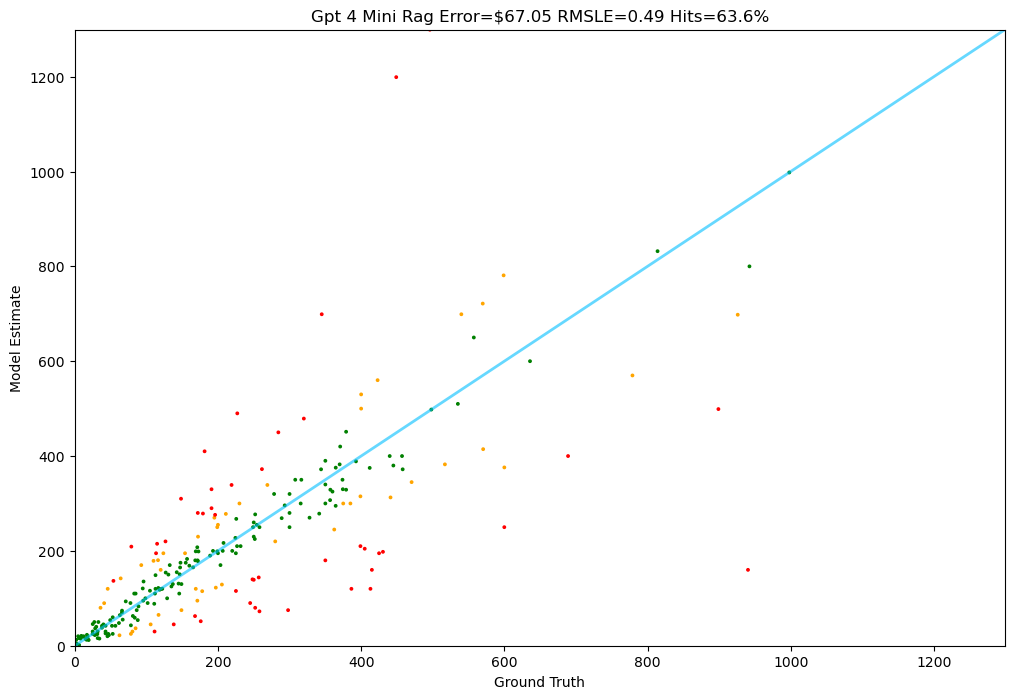

In [47]:
Tester.test(gpt_4_mini_rag, test)